# Advanced HuggingFace Pipelines Exploration

This notebook provides an in-depth exploration of HuggingFace's high-level `pipeline` API. We'll cover various tasks including text classification (sentiment analysis), text generation, text-to-text generation (translation and summarization), image classification, and text-to-image generation.

We'll use GPU acceleration where possible for better performance, especially for image-related tasks. This notebook is designed to run on Google Colab with a T4 GPU for optimal results.

## Setup Instructions
- Run this in Google Colab: [Link to Colab](https://colab.research.google.com/drive/1aMaEw8A56xs0bRM4lu8z7ou18jqyybGm?usp=sharing)
- Set up your HuggingFace token: Go to Settings > Secrets, add `HF_TOKEN` with your token from https://huggingface.co/settings/tokens.
- Select GPU runtime: Runtime > Change runtime type > T4 GPU.

## Prerequisites
- Basic Python knowledge
- Familiarity with machine learning concepts

In [1]:
# Pip installs should come at the top line.
# If your Kernel ever resets, you need to run this again.

!pip install -q --upgrade datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00


In [2]:
# Let's check the GPU - it should be a Tesla T4

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('Tesla T4') >= 0:
    print("Success - Connected to a T4")
  else:
    print("NOT CONNECTED TO A T4")

Mon Oct 20 19:48:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Imports

import torch
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline
from diffusers import DiffusionPipeline
from datasets import load_dataset
import soundfile as sf
from IPython.display import Audio

## Fix HF token


In [4]:
hf_token = userdata.get('HF_TOKEN')
if hf_token and hf_token.startswith("hf_"):
  print("HF key looks good so far")
else:
  print("HF key is not set - please click the key in the left sidebar")
login(hf_token, add_to_git_credential=True)

HF key looks good so far


## 1. Sentiment Analysis (Text Classification)

We'll use the sentiment-analysis pipeline to classify text as positive or negative.

Best practices: Use batching for multiple texts, return all scores for detailed analysis.

In [7]:
from transformers import pipeline

my_simple_sentiment_analyzer = pipeline("sentiment-analysis", device="cuda")
texts = ["I love this product!", "This is disappointing.", "Absolutely fantastic experience."]
results = my_simple_sentiment_analyzer(texts, return_all_scores=True)

for text, result in zip(texts, results):
    print(f"Text: {text}")
    for score in result:
        print(f"  {score['label']}: {score['score']:.4f}")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


Text: I love this product!
  NEGATIVE: 0.0001
  POSITIVE: 0.9999
Text: This is disappointing.
  NEGATIVE: 0.9998
  POSITIVE: 0.0002
Text: Absolutely fantastic experience.
  NEGATIVE: 0.0001
  POSITIVE: 0.9999


In [8]:
result = my_simple_sentiment_analyzer("I should be more excited to be on the way to LLM mastery!")
print(result)

[{'label': 'POSITIVE', 'score': 0.9008274674415588}]


In [9]:
better_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device="cuda")
result = better_sentiment("I should be more excited to be on the way to LLM mastery!!")
print(result)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda


[{'label': '3 stars', 'score': 0.39448031783103943}]


## 2. Named Entity Recognition (NER) using Hugging Face

This example demonstrates how to use Hugging Face's `pipeline` for Named Entity Recognition (NER).
We will identify entities such as organizations, locations, and people in a given text.


In [10]:
# Named Entity Recognition

ner = pipeline("ner", device="cuda")
result = ner("AI Engineers are learning about the amazing pipelines from HuggingFace in Google Colab from Ed Donner")
for entity in result:
  print(entity)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda


{'entity': 'I-ORG', 'score': np.float32(0.999476), 'index': 1, 'word': 'AI', 'start': 0, 'end': 2}
{'entity': 'I-ORG', 'score': np.float32(0.9962089), 'index': 2, 'word': 'Engineers', 'start': 3, 'end': 12}
{'entity': 'I-ORG', 'score': np.float32(0.8205678), 'index': 11, 'word': 'Hu', 'start': 59, 'end': 61}
{'entity': 'I-ORG', 'score': np.float32(0.651493), 'index': 12, 'word': '##gging', 'start': 61, 'end': 66}
{'entity': 'I-ORG', 'score': np.float32(0.960993), 'index': 13, 'word': '##F', 'start': 66, 'end': 67}
{'entity': 'I-ORG', 'score': np.float32(0.92517126), 'index': 14, 'word': '##ace', 'start': 67, 'end': 70}
{'entity': 'I-MISC', 'score': np.float32(0.8882749), 'index': 16, 'word': 'Google', 'start': 74, 'end': 80}
{'entity': 'I-MISC', 'score': np.float32(0.67307675), 'index': 17, 'word': 'Cola', 'start': 81, 'end': 85}
{'entity': 'I-PER', 'score': np.float32(0.9989441), 'index': 20, 'word': 'Ed', 'start': 92, 'end': 94}
{'entity': 'I-PER', 'score': np.float32(0.99872154), 'i

## 3. Question Answering with Context

In this example, we use Hugging Face's `pipeline` for question answering.  
We provide a **context** paragraph and ask a **question**, and the model will extract the answer from the context.


In [11]:
# Question Answering with Context

question="What are Hugging Face pipelines?"
context="Pipelines are a high level API for inference of LLMs with common tasks"

question_answerer = pipeline("question-answering", device="cuda")
result = question_answerer(question=question, context=context)
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


{'score': 0.24576981365680695, 'start': 35, 'end': 70, 'answer': 'inference of LLMs with common tasks'}


## 4. Text Generation

Generate text from a prompt using a causal language model.

Best practices: Control output with max_new_tokens, temperature for creativity. Use batching for multiple prompts.

In [12]:
generator = pipeline("text-generation", model="gpt2", device="cuda")
prompts = ["In the year 2050, AI will", "The best way to learn programming is"]
results = generator(prompts, max_new_tokens=50, do_sample=True, temperature=0.7, num_return_sequences=2)

for prompt, gens in zip(prompts, results):
    print(f"Prompt: {prompt}")
    for i, gen in enumerate(gens):
        print(f"Generation {i+1}: {gen['generated_text']}\n")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: In the year 2050, AI will
Generation 1: In the year 2050, AI will be the dominant driver of AI that will take our society to new heights," said Professor David O'Brien, head of the department of cognitive psychology at Cambridge University. "This is something that is very promising for the future of science, and for humanity

Generation 2: In the year 2050, AI will become the most advanced form of machine learning, with the potential to increase the number of people in the world by nearly half a billion.

This is a key milestone for AI and the field of artificial intelligence, where there are now more than 1

Prompt: The best way to learn programming is
Generation 1: The best way to learn programming is to study the basics of programming. But you need to be a programming knowledge expert to learn programming.

Now you know what libraries and frameworks are really all about. So let's take a look at some of the best libraries and frameworks, and

Generation 2: The best way to lea

### 5. Text-to-Text Generation: Translation and Summarization

### Translation
Translate text from English to French.



In [13]:
# Text Summarization

summarizer = pipeline("summarization", device="cuda")
text = """
The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing (NLP).
It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering, among others.
It's an extremely popular library that's widely used by the open-source data science community.
It lowers the barrier to entry into the field by providing Data Scientists with a productive, convenient way to work with transformer models.
"""
summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cuda


 The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing . It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering .


In [14]:
# Translation

translator = pipeline("translation_en_to_fr", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

No model was supplied, defaulted to google-t5/t5-base and revision a9723ea (https://huggingface.co/google-t5/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


Les Data Scientists ont été vraiment étonnés par la puissance et la simplicité de l'API du pipeline HuggingFace.


In [15]:
# Another translation, showing a model being specified
# All translation models are here: https://huggingface.co/models?pipeline_tag=translation&sort=trending

translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda


Los científicos de datos estaban verdaderamente sorprendidos por el poder y la simplicidad de la API de tuberías HuggingFace.


## 6. Zero-Shot Text Classification

In this example, we use Hugging Face's `zero-shot-classification` pipeline.  
We provide a text along with a list of candidate labels, and the model predicts which label(s) best describe the text—even if it hasn't seen them during training.


In [16]:
# Classification

classifier = pipeline("zero-shot-classification", device="cuda")
result = classifier("Hugging Face's Transformers library is amazing!", candidate_labels=["technology", "sports", "politics"])
print(result)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


{'sequence': "Hugging Face's Transformers library is amazing!", 'labels': ['technology', 'sports', 'politics'], 'scores': [0.9493839740753174, 0.03225007280707359, 0.018365919589996338]}


## 7. Text-to-Image Generation

Generate images from text prompts using a diffusion model (requires GPU for best results).

Using FLUX.1-schnell, a fast and high-quality model from 2025.

Best practices: Use bfloat16 for efficiency, enable CPU offload if memory is limited.

model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/4 [00:00<?, ?it/s]

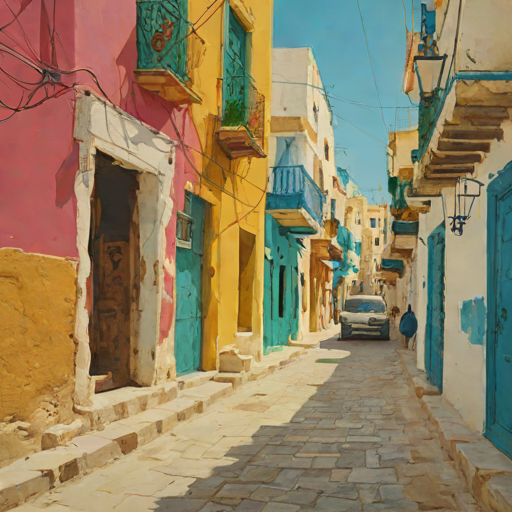

In [18]:

from IPython.display import display
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")
prompt = "A vibrant Tunisian street scene in an artistic, painterly style"
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0.0).images[0]
display(image)

## 8. Text-to-Speech / Audio Generation

Generate high-quality speech from text using a pretrained TTS (Text-to-Speech) model.

In this example, we use **microsoft/speecht5_tts** to synthesize audio.  
You can provide **speaker embeddings** for voice personalization, and the output can be played directly in the notebook.

**Best practices:**
- Use GPU for faster generation.
- Use pretrained speaker embeddings for consistent voice characteristics.
- Adjust forward parameters for voice style, pitch, and speed.


In [19]:
# Audio Generation

from transformers import pipeline
from datasets import load_dataset
import soundfile as sf
import torch
from IPython.display import Audio

synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts", device='cuda')
embeddings_dataset = load_dataset("matthijs/cmu-arctic-xvectors", split="validation", trust_remote_code=True)
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
speech = synthesiser("Hi to a great person, on the way to mastery!", forward_params={"speaker_embeddings": speaker_embedding})

Audio(speech["audio"], rate=speech["sampling_rate"])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Device set to use cuda


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

cmu-arctic-xvectors.py: 0.00B [00:00, ?B/s]

spkrec-xvect.zip:   0%|          | 0.00/17.9M [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

## Performance Tips and Best Practices

- **Batching**: Use for throughput on large datasets, but test batch_size to avoid OOM errors.
- **Precision**: Use `torch.float16` or `bfloat16` on GPU for faster inference.
- **Streaming**: For large datasets, use `datasets` library with `KeyDataset`.
- **Custom Models**: Specify model names for specialized tasks.
- **Error Handling**: Wrap in try-except for robust code.

## Conclusion

This notebook demonstrates the power and simplicity of HuggingFace pipelines. Experiment with different models and prompts!